### **First Update (12/21/21):**
<br>
I was able to make a DataFrame that stores the interpolated points and can correctly plot each point in a facet plot to the curve. I haven't been able to handle the background subtraction, so making a df_melted 2.0 will be needed to map the background subtraction. Since each interpolated point does not exactly line up to the measurements from the background, I have some options: take a mean/median of the background and subtract that value, use the closest measured background point, or subtracting an interpolated background measurement. I was also able to figure out the `geom_hline()` function along with its parameters.

### **Second Update (2/2/22):**
<br>
One of the Figures that is in the Introduction of my work shows graphically and abstractly (there are no data involved in making it- I made it in PowerPoint) the different features that AMiGA can extract. I am interested in making an actual plot that uses data from a previous experiment (11/12/21 in this case) more or less replicate what I wanted to make. This would be a very nice close to the discussion that I opened with in the introduction. There are still some things that I need to address:
<body>
    <ul>
        <li>Time of Maximum Growth: Fixing Sensitivity to Biproduct of Machine</li>
            <ul>
                <li>Truncate the data by hand and use a select range to find the true biological time of maximum growth. Benefit: Work with untouched, real data. Cost: Requires either user input or a smart truncating program.</li>
                <li>Use the Gaussian Process Curve from the derived data from AMiGA and trust that the smoothened data will provide an accurate time of maximum growth. Benefit: No user input required since supplied by AMiGA. Cost: Works with smoothened data.</li>
            </ul>
        <li>Background Subtraction: Enable subtracted values for appropriate AMiGA parameters</li>
    </ul>
</body>

### **Third Update (2/4/22):**
<br>
I was able to automate my plots such that they can be Background or non-Background subtracted when applicable. The way that I perform the subtraction could be subject to change, but I have a consistent method of performing them and plotting them. The next notebook I make will be a condensed version of this and not feature the intermediate plots. Hopefully the length of the new notebook is much shorter- working in a document at this length is tiresome and can be confusing.

### Context Behind Data (4/28/22)

These data are from my plate reader experiments (seven in total) referenced in my senior thesis.

### Start of Code

In [1]:
## Goal of the Chunk: Load in necessary packages
import pandas as pd
import os
import plotnine
import numpy as np
from plotnine import *
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.4f}".format # display float values to four decimal places
import utilities

background_subtraction = True

In [2]:
## Goal of the Chunk: Creating a callable function for data processing
# This function will be used iteratively for the different experiments

def plot_processing(amiga_imported_summary:str, df_melted_i:str, exp_no:int):
    
    ## Goal of the Chunk: Checking that my modified output is loaded correctly

    # Reading in my data- a customized output
    amiga_imported = pd.read_excel(amiga_imported_summary)

    # These are time values from AMiGA in Hours.
    # I plot in minutes, so these all need to be multiplied by 60
    amiga_imported["lagC_adj"] = amiga_imported["lagC"] * 60
    amiga_imported["lagP_adj"] = amiga_imported["lagP"] * 60
    amiga_imported["t_gr_adj"] = amiga_imported["t_gr"] * 60
    amiga_imported["t_dr_adj"] = amiga_imported["t_dr"] * 60
    amiga_imported["t_k_adj"] = amiga_imported["t_k"] * 60

    # Looking at a subset
    amiga_imported[25:28]

    # The interpolated_y values are showing up as objects because of the first nan.
    for col in amiga_imported:
        if col[:15] == "Interpolated_OD":
            amiga_imported[col] = pd.to_numeric(amiga_imported[col], "coerce")
    
    ## Goal of the Chunk: Loading in processed data from the df_melted portion of the plate_reader_analysis notebook

    # This contains helpful data processing from the original plotting notebook
    df_melted = pd.read_excel(df_melted_i, usecols=lambda x: 'Unnamed' not in x,)
    wells_used = df_melted["Well"].unique().tolist()
    df_melted = df_melted.drop(columns = ["Group", "Control"])

    ## Goal of the Chunk: Performing unit analysis on the Time
    ## AMiGA deals in hours, but I plot in minutes, therefore a conversion is necessary
    ## The Times that are interpolated for are in the Interpolated_OD_XXX columns

    # Don't want to directly modify my original copy
    amiga_imported_summary = amiga_imported
    amiga_imported_adj = amiga_imported_summary

    # I'm plotting in seconds while the times are provided in minutes.
    for col in amiga_imported_adj:
        if col[:13] == "Interpolated_":
            if col[13:15] == "OD":
                column_name = col
                column_name_adj = col + "_adj"
                # https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
                amiga_imported_adj[column_name] = pd.to_numeric(amiga_imported_adj[column_name], errors='coerce')
                amiga_imported_adj[column_name_adj] = amiga_imported_adj[column_name] * 60
    amiga_imported_adj[25:28]
    
    ## Goal of the Chunk: Handling the OD Values
    ## The OD values (y-values) are in the column name 
    ## while the Time values (x-values) are the values within the column.
    ## The OD values are all shared while the Times are not necessarily shared

    # Times will be stored in interpolation_x and OD values will be in interpolation_y
    interpolation_x = []
    interpolation_y = []
    # This will store the created DataFrames in a list.
    # Each DataFrame will be for a particular OD value and contains all wells
    list_frames_od = []

    # This for loop determines which columns are appropriate to select
    for col in amiga_imported_adj:
        if col[:12] == "Interpolated":
            if col[13:15] == "OD":
                if col[-4:] == "_adj":
                    # Finding the OD values with the adjusted Time from hours to minutes
                    interpolation_x.append(amiga_imported_adj[col].tolist())
                else:
                    # Isolating the OD value interpolated for from the column name and turning it into a float
                    interpolation_y_value = col[16:]
                    interpolation_y_value = float(interpolation_y_value)
                    # Essential for preserving the dimensions for a soon-to-be-created DataFrame
                    for i in range(96):
                        interpolation_y.append(interpolation_y_value)

    # The previous portions involve lists, so this method splices the lists and results in a DataFrame
    y_start = 0
    y_end = 96
    for i in range(len(interpolation_x)): 
        list_frames_od.append(pd.DataFrame(interpolation_x[i], interpolation_y[y_start:y_end]).reset_index().rename(columns = {"index": "interpolation_y", 0:"interpolation_x"}))
        y_start += 96
        y_end += 96


    ## Goal of the Chunk: Handling the Time Values
    ## The OD values (y-values) are within the columns 
    ## while the Time values (x-values) are the values in the column names.
    ## The OD values are all shared while the Times are not necessarily shared

    # Times will be stored in interpolation_x and OD values will be in interpolation_y
    interpolation_x = []
    interpolation_y = []
    # This will store the created DataFrames in a list.
    # Each DataFrame will be for a particular Time and contains all wells
    list_frames_time = []

    # Same thought process as the OD value for loop, but this time, with Time
    for col in amiga_imported_adj:
        if col[:12] == "Interpolated":
            if col[13:17] == "Time":
                interpolation_y.append(amiga_imported_adj[col].tolist())
                interpolation_x_value = col[18:]
                # I extract the time interpolated for, which was not adjusted when making the *_adj columns.
                # (The Time interpolated for was hidden in the column name as a string)
                interpolation_x_value = float(interpolation_x_value) * 60
                for i in range(96):
                    interpolation_x.append(interpolation_x_value)


    # Same thought process as the OD value for loop, but this time, with Time
    x_start = 0
    x_end = 96
    for i in range(len(interpolation_y)): 
        list_frames_time.append(pd.DataFrame(interpolation_x[x_start:x_end], interpolation_y[i]).reset_index().rename(columns = {"index": "interpolation_y", 0:"interpolation_x"}))
        x_start += 96
        x_end += 96

    ## Goal of the Chunk: Making one collective list with all values interpolated for
    all_interpolated = list_frames_od + list_frames_time
    
    ## Goal of the Chunk: Combining everything into a single DataFrame

    # Creating a blank template.
    # Running pd.concat repeatedly without wiping the slate clean between each iteration
    # will lead to a double-counting nightmare.
    columns_to_create = {"interpolation_y": [], "interpolation_x": []}
    pivot_twist = pd.DataFrame(columns_to_create)

    # the watermark of a novice coder
    counter = 0

    # There could be a case where only one additional value is requested.
    # I don't want my code to break between more than one versus only one
    for frame in all_interpolated:
        if counter == 0:
            pivot_twist_complete = pd.concat([pivot_twist, frame])
            counter += 1
        else:
            pivot_twist_complete = pd.concat([pivot_twist_complete, frame])

    # In the previous stored version, the index went from 0-96 several times.
    # Resetting the index and then changing the column name to Sample_ID is a better representation.
    # The new index is now unique and makes more sense.
    pivot_twist_complete = pivot_twist_complete.reset_index().rename(columns = {"index": "Sample_ID"})
    pivot_twist_complete = pivot_twist_complete[["Sample_ID", "interpolation_x", "interpolation_y"]]

    
    ## Goal of the Chunk: Bring over the well information
    pivot_imported = pd.merge(pivot_twist_complete, amiga_imported, on = "Sample_ID")
    # Selecting only the columns that I need to reduce the horizontal scroll of death
    pivot_imported = pivot_imported[["Sample_ID", "Well", "interpolation_x", "interpolation_y"]]

    ## Goal of the Chunk: Make the Plate_Row and Plate_Column columns to be compatible with the facet plot

    # Making a list to store the values that will be inserted in the updated DataFrame
    plate_column = []
    plate_row = []

    # Taking the first character as the plate Row and following the first character is the column
    for well in pivot_imported["Well"]:
        plate_row.append(well[:1])
        # The default way was to store as an object, which creates problems in the merge with a dtypes mismatch
        plate_column.append(int(well[1:]))

    # Making a new DataFrame with the well information obtained via previous for loop
    wells_df = pd.DataFrame({"Plate_Column": plate_column, "Plate_Row": plate_row})

    # Updating the pivot_imported DataFrame with its own Well information
    pivot_complete = pd.concat([wells_df, pivot_imported], axis = 1)
    # Reordering the DataFrame in a way that's more consistent with previous representations
    pivot_complete = pivot_complete[["Sample_ID", "Well", "Plate_Row", "Plate_Column", "interpolation_x", "interpolation_y"]]
    # Only including used wells.
    # Unused wells either have NA or non-helpful values that would negatively distort the facet
    pivot_complete = pivot_complete[(pivot_complete.Well.isin(wells_used))] 

    
    ## Goal of the Chunk: Have background subtracted OD-value interpolation 
    # I borrowed the format from the plate_reader_analysis_.*
    # The main challenge was to map the interpolated value to the correct background
    df_melted_cols = []

    df_melted_sample_id = pd.merge(df_melted, amiga_imported, how = "inner")

    for col in df_melted:
        df_melted_cols.append(col)
    df_melted_cols.append("Sample_ID")

    df_melted_sample_id = df_melted_sample_id[df_melted_cols]

    melted_pivot = pd.merge(df_melted_sample_id, pivot_twist_complete, on = "Sample_ID")

    list_cols_to_adj = ["interpolation_y"]

    # first let's try to extract background data
    bgd_name= 'Blank' # just change it to whatever you called it - blank, empty, media etc

    # now this should add new column with correct background reading based on channel, cycle, background gp
    for col_adj in list_cols_to_adj:
        adj_name = "Bgd_s_" + col_adj
        if background_subtraction == True:
        #     the background to subtract is the same for each time point
        #     now make a new column that subtracts background from reading
            melted_pivot[adj_name]=melted_pivot[col_adj]-melted_pivot['background_reading']
        else:
            pass

    # For extra security:
    # This reorders the final_df alphabetically and numerically (e.g. A1 first, H12 last if full plate)
    melted_pivot = melted_pivot.sort_values(by = ["Plate_Row", "Plate_Column"], ignore_index = True)
    # This data frame is tidy
    channels_to_keep = ["Sample_ID", "Well", "Plate_Row", "Plate_Column", "background_reading",
                        "interpolation_x", "interpolation_y", "Bgd_s_interpolation_y"]
    melted_pivot = melted_pivot[channels_to_keep]
    
    
    ## Goal of the Chunk: Running background subtraction on AMiGA OD-values
    background_subtraction == True
    # I need to join these two bits of information to map the background conditions (df_melted)
    # to the AMiGA data (amiga_imported_df)
    melted_amiga = pd.merge(df_melted, amiga_imported_adj)
    # These are in regular units of OD
    list_cols_to_adj = ["Reading", "k_lin", "k_log", "death_lin", "death_log", "OD_Max", "OD_Min"]
    # This is also OD, but represented as an area. This is a different concept
    list_cols_to_adj_auc = ["auc_lin", "auc_log"]


    # first let's try to extract background data
    bgd_name= 'Blank' # just change it to whatever you called it - blank, empty, media etc

    # now this should add new column with correct background reading based on channel, cycle, background gp
    for col_adj in list_cols_to_adj:
        adj_name = "Bgd_s_" + col_adj
        if background_subtraction == True:
        #     the background to subtract is the same for each time point
        #     now make a new column that subtracts background from reading
            melted_amiga[adj_name] = melted_amiga[col_adj]-melted_amiga['background_reading']
        else:
            pass

    # Repeating the process, this time subtracting what the background AUC should be    
    for col_adj in list_cols_to_adj_auc:
        adj_name = "Bgd_s_" + col_adj
        background_type = "background_auc_" + col_adj[-3:]
        if background_subtraction == True:
        #     the background to subtract is the same for each time point
        #     now make a new column that subtracts background from reading
            melted_amiga[adj_name] = melted_amiga[col_adj]-melted_amiga["background_reading"]
        else:
            pass

    # For extra security:
    # This reorders the final_df alphabetically and numerically (e.g. A1 first, H12 last if full plate)
    melted_amiga = melted_amiga.sort_values(by = ["Plate_Row", "Plate_Column"], ignore_index = True)
    # # This data frame is tidy
    melted_amiga
    
    
    ## Goal of the Chunk: Setting up unit conversions

    # Deciding what the duration of the experiment is along with other modifications
    melted_to_use = melted_amiga
    # melted_to_use = df_melted
    melted_to_use = melted_to_use.rename(columns={"Time [s]": "Time"})
    melted_to_use.Time = np.where(melted_to_use.Time, melted_to_use.Time // 3600 + melted_to_use.Time // 60, melted_to_use.Time)
    melted_to_use["Condition"] = melted_to_use["Condition"].astype(str)
    melted_to_use["Strain"] = melted_to_use["Strain"].astype(str)
    endpt = int(round(melted_to_use["Time"].max() // 60, 0) + 1)

    ## Goal of the Chunk: Merging information between updated df_melted and the amiga data
    merged_m_a = pd.DataFrame()
    merged_m_a = pd.merge(melted_to_use, amiga_imported)
    
    ## Goal of the Chunk: Updating the conditions with more graph-friendly names
    merged_m_a_condensed = merged_m_a.replace({"M9GCAA": "M9C", "IMDM": "I", "IMDMF": "F"}, regex = True)
    merged_m_a_condensed = merged_m_a_condensed.replace({"IFCAd": "FC"}, regex = True)
    merged_m_a_condensed
    
    ## Goal of the Chunk: Automate selecting the position of the condition labels for the overall facet plots
    # Running calculations for y_label_pos 
    # Grouping by channel and calculating the median fluorescence value and resetting the index
    grouped_melted = df_melted.groupby(["Channel"]).median().reset_index()
    # Selecting only the columns that matter (Channel used as a key, everything else will be added)
    grouped_melted = grouped_melted[["Channel", "Reading", "background_reading", "Bgd_subtracted_reading"]]
    # Creating a blank dataframe to reset when this cell is run more than once
    combined = pd.DataFrame()
    # Merging df_melted and grouped_melted using "Channel" as the key, or unique identifier for each observation
    combined = pd.merge(df_melted, grouped_melted, on = ["Channel"])
    # When you merge dataframes with the same column name, one gets _x and the other _y to not overwrite the other
    # Reading_x is the original reading, Reading_y is the median calculated in the original 'group_by()' function
    combined = combined.rename(columns = {"Reading_x":"Reading", "background_reading_x": "background_reading"})
    
    ## Goal of the Chunk: Calculating the average lag time per condition per strain
    merged_melted = merged_m_a_condensed.groupby(["Condition", "Strain"]).mean().reset_index()
    merged_melted = merged_melted[["Condition", "Strain", "lagC"]]
    merged_melted = merged_melted.rename(columns = {"lagC": "average_lagC"})

    # Bringing over the rest of the data
    combined_new = pd.DataFrame()
    combined_new = pd.merge(merged_m_a, merged_melted, on = ["Condition", "Strain"])
    data_to_use = combined_new
    
    ## Goal of the Chunk: Calculating the collected average from the triplicates
    # This is important for the AUC plots that require the average to be calculated beforehand.
    # I then filter out the blanks.
    average_lagC_list = []
    for row in combined_new["average_lagC"]:
        if row in average_lagC_list:
            pass
        else:
            average_lagC_list.append(row)


    average_lagC_list_seconds = []

    for value in average_lagC_list:
        average_lagC_list_seconds.append(value)


    combined_unique = combined_new[combined_new["average_lagC"].isin(average_lagC_list_seconds)].drop_duplicates("average_lagC")
    combined_unique["average_lagC_adj"] = combined_unique["average_lagC"] * 60

    # list_to_combine_on = ["Channel", "Cycle Nr.", "Time", "Well", "Reading", "Condition", "Background_group", "Strain", "Plate_Row", "Plate_Column", "background_reading", "Bgd_subtracted_reading", "average_lagC"]
    combined_full = pd.merge(combined_new, combined_unique, how = "inner")
    combined_full_no_blank = combined_full[combined_full.Condition!="Blank"]
    combined_full_no_blank = combined_full_no_blank.sort_values("Condition")
    combined_full_no_blank
    
    
    ## Goal of the Chunk: Incorporating the experiment number in the DataFrames
    merged_m_a["Exp_No"] = exp_no
    merged_m_a_condensed["Exp_No"] = exp_no
    combined_new["Exp_No"] = exp_no
    combined_full_no_blank["Exp_No"] = exp_no
    melted_pivot["Exp_No"] = exp_no
    
    return endpt, merged_m_a, merged_m_a_condensed, combined_new, combined_full_no_blank, melted_pivot

In [3]:
## Goal of the Chunk: Identifying the files for data processing
output_list = []
df_melted_list = []

for file in os.listdir("data"):
    if file[:3] == "cus":
        output_list.append(os.path.join("data", file))
    elif file[:3] == "df_":
        df_melted_list.append(os.path.join("data", file))
        
test_output = output_list[0]
test_df_melted = df_melted_list[0]

In [4]:
## Goal of the Chunk: Append information to the correct lists

endpt_list = []
merged_m_a_list = []
merged_m_a_condensed_list = []
combined_new_list = []
combined_full_no_blank_list = []
melted_pivot_list = []


for output, melted, exp_no in zip(output_list, df_melted_list, range(1, len(output_list)+1)):
    function_run = plot_processing(output, melted, exp_no)
    endpt_list.append(function_run[0])
    merged_m_a_list.append(function_run[1])
    merged_m_a_condensed_list.append(function_run[2])
    combined_new_list.append(function_run[3])
    combined_full_no_blank_list.append(function_run[4])
    melted_pivot_list.append(function_run[5])

In [5]:
melted_pivot_list[0]

,Sample_ID,Well,Plate_Row,Plate_Column,background_reading,interpolation_x,interpolation_y,Bgd_s_interpolation_y,Exp_No
0,13,B2,B,2,0.0870,nan,60.0000,59.9130,1
1,13,B2,B,2,0.0870,nan,0.5000,0.4130,1
2,13,B2,B,2,0.0870,nan,0.4000,0.3130,1
3,13,B2,B,2,0.0870,nan,0.2000,0.1130,1
4,13,B2,B,2,0.0870,nan,0.3000,0.2130,1
...,...,...,...,...,...,...,...,...,...
150535,82,G11,G,11,0.0837,900.0000,0.6299,0.5462,1
150536,82,G11,G,11,0.0837,315.0000,0.3673,0.2836,1
150537,82,G11,G,11,0.0837,165.0000,0.1829,0.0993,1
150538,82,G11,G,11,0.0837,90.0000,0.1186,0.0349,1


In [6]:
## Goal of the Chunk: Defining a function to efficiently concatenate objects
def concat_function(template, list_dfs_to_concat:list):
    df = template
    for df_to_concat in list_dfs_to_concat:
        df = pd.concat([df, df_to_concat])

    return df

In [7]:
## Goal of the Chunk: Concatenate separate dataframes to one, respectively
merged_m_a = pd.DataFrame(columns = merged_m_a_list[0].columns)
merged_m_a_condensed = pd.DataFrame(columns = merged_m_a_condensed_list[0].columns)
combined_new = pd.DataFrame(columns = combined_new_list[0].columns)
combined_full_no_blank = pd.DataFrame(columns = combined_full_no_blank_list[0].columns)
melted_pivot = pd.DataFrame(columns = melted_pivot_list[0].columns)

list_dfs_to_concat = [merged_m_a_list, merged_m_a_condensed_list,
                      combined_new_list, combined_full_no_blank_list,
                      melted_pivot_list
                     ]
list_dfs_to_concat_name = ["merged_m_a_list", "merged_m_a_condensed_list",
                      "combined_new_list", "combined_full_no_blank_list",
                      "melted_pivot_list"
                     ]
list_templates = [merged_m_a, merged_m_a_condensed,
                  combined_new, combined_full_no_blank,
                  melted_pivot
                 ]

merged_m_a = concat_function(merged_m_a, merged_m_a_list)
merged_m_a_condensed = concat_function(merged_m_a_condensed, merged_m_a_condensed_list)
combined_new = concat_function(combined_new, combined_new_list)
combined_full_no_blank = concat_function(combined_full_no_blank, combined_full_no_blank_list)
melted_pivot = concat_function(melted_pivot, melted_pivot_list)
endpt = max(endpt_list)

In [8]:
melted_pivot

,Sample_ID,Well,Plate_Row,Plate_Column,background_reading,interpolation_x,interpolation_y,Bgd_s_interpolation_y,Exp_No
0,13,B2,B,2,0.0870,nan,60.0000,59.9130,1
1,13,B2,B,2,0.0870,nan,0.5000,0.4130,1
2,13,B2,B,2,0.0870,nan,0.4000,0.3130,1
3,13,B2,B,2,0.0870,nan,0.2000,0.1130,1
4,13,B2,B,2,0.0870,nan,0.3000,0.2130,1
...,...,...,...,...,...,...,...,...,...
150535,82,G11,G,11,0.0777,900.0000,0.7694,0.6917,7
150536,82,G11,G,11,0.0777,315.0000,0.1322,0.0546,7
150537,82,G11,G,11,0.0777,165.0000,0.1023,0.0246,7
150538,82,G11,G,11,0.0777,90.0000,0.0891,0.0114,7


In [9]:
# Setting a plot path
plot_path = "plots\\"

# Setting the dimensions
figure_height = 12
figure_width = 6

For the next two plots, I need to figure out a way to incorporate the background subtracted values in there or not.

In [10]:
data_to_plot = merged_m_a_condensed[merged_m_a_condensed.Condition!="Blank"]
data_to_plot

,Channel,Cycle Nr.,Time,Well,Reading,Condition,Background_group,Strain,Plate_Row,Plate_Column,...,Bgd_s_Reading,Bgd_s_k_lin,Bgd_s_k_log,Bgd_s_death_lin,Bgd_s_death_log,Bgd_s_OD_Max,Bgd_s_OD_Min,Bgd_s_auc_lin,Bgd_s_auc_log,Exp_No
193,OD600,1,4,B3,0.0880,10_r_m,M9G_s,STm14028,B,3,...,0.0010,0.2786,1.5507,-0.0835,-0.0793,0.3680,0.0010,4.1061,20.3591,1
194,OD600,2,9,B3,0.0880,10_r_m,M9G_s,STm14028,B,3,...,0.0010,0.2786,1.5507,-0.0835,-0.0793,0.3680,0.0010,4.1061,20.3591,1
195,OD600,3,14,B3,0.0890,10_r_m,M9G_s,STm14028,B,3,...,0.0020,0.2786,1.5507,-0.0835,-0.0793,0.3680,0.0010,4.1061,20.3591,1
196,OD600,4,19,B3,0.0900,10_r_m,M9G_s,STm14028,B,3,...,0.0033,0.2789,1.5511,-0.0832,-0.0790,0.3683,0.0013,4.1064,20.3594,1
197,OD600,5,24,B3,0.0910,10_r_m,M9G_s,STm14028,B,3,...,0.0043,0.2789,1.5511,-0.0832,-0.0790,0.3683,0.0013,4.1064,20.3594,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11575,OD600,189,959,G11,0.7640,10000_r_m,M9G_s,STm14028,G,11,...,0.6865,0.6102,2.1618,-0.0674,-0.0643,0.6975,0.0045,4.5740,18.8283,7
11576,OD600,190,964,G11,0.7600,10000_r_m,M9G_s,STm14028,G,11,...,0.6825,0.6102,2.1618,-0.0674,-0.0643,0.6975,0.0045,4.5740,18.8283,7
11577,OD600,191,969,G11,0.7620,10000_r_m,M9G_s,STm14028,G,11,...,0.6845,0.6102,2.1618,-0.0674,-0.0643,0.6975,0.0045,4.5740,18.8283,7
11578,OD600,192,974,G11,0.7630,10000_r_m,M9G_s,STm14028,G,11,...,0.6853,0.6100,2.1616,-0.0676,-0.0645,0.6973,0.0043,4.5738,18.8282,7


## Magnesium

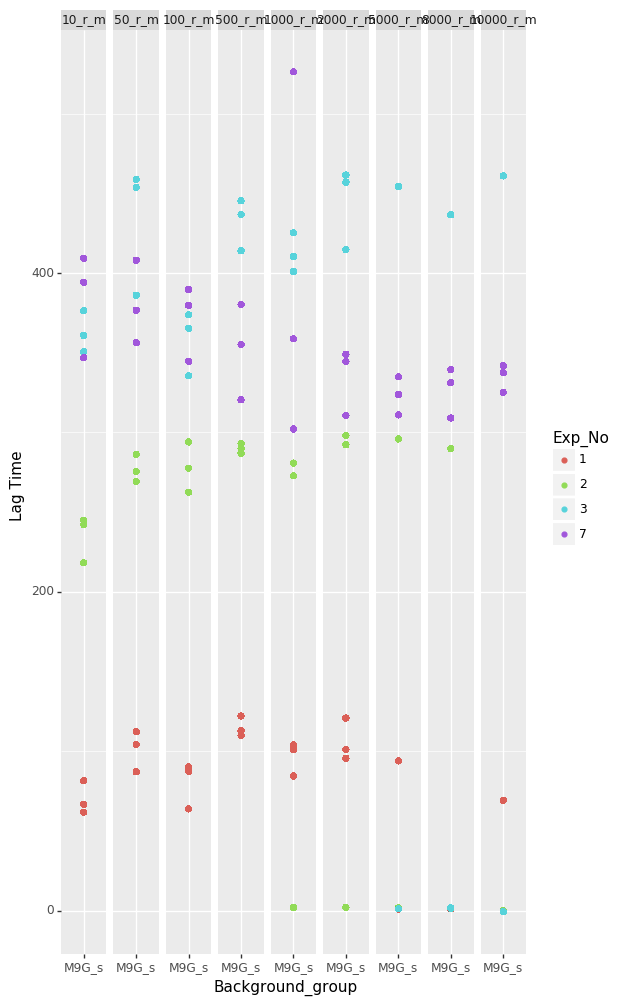

<ggplot: (-9223371959023290196)>


In [11]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj"
condition_subset = ["10_r_m", "50_r_m", "100_r_m",
                      "500_r_m", "1000_r_m", "2000_r_m",
                      "5000_r_m", "8000_r_m", "10000_r_m"
                     ]
condition_type = "magnesium"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(data_to_plot_sub, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point() +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

In [12]:
pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == 1][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj']]
pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
norm_value = pilot_g[pilot_g["Condition"] == "2000_r_m"]["lagC_adj"].tolist()[0]
pilot_g["lagC_adj_norm"] = pilot_g["lagC_adj"] / norm_value
pilot_g

,Condition,Reading,lagC_adj,lagC_adj_norm
0,10_r_m,0.3475,70.0320,0.6616
1,50_r_m,0.4840,101.1524,0.9557
2,100_r_m,0.5505,80.4404,0.7600
3,500_r_m,0.5513,114.9240,1.0858
4,1000_r_m,0.5710,96.4927,0.9116
5,2000_r_m,0.5436,105.8450,1.0000
6,5000_r_m,0.5074,32.1436,0.3037
7,8000_r_m,0.4769,1.1973,0.0113
8,10000_r_m,0.5225,22.9248,0.2166


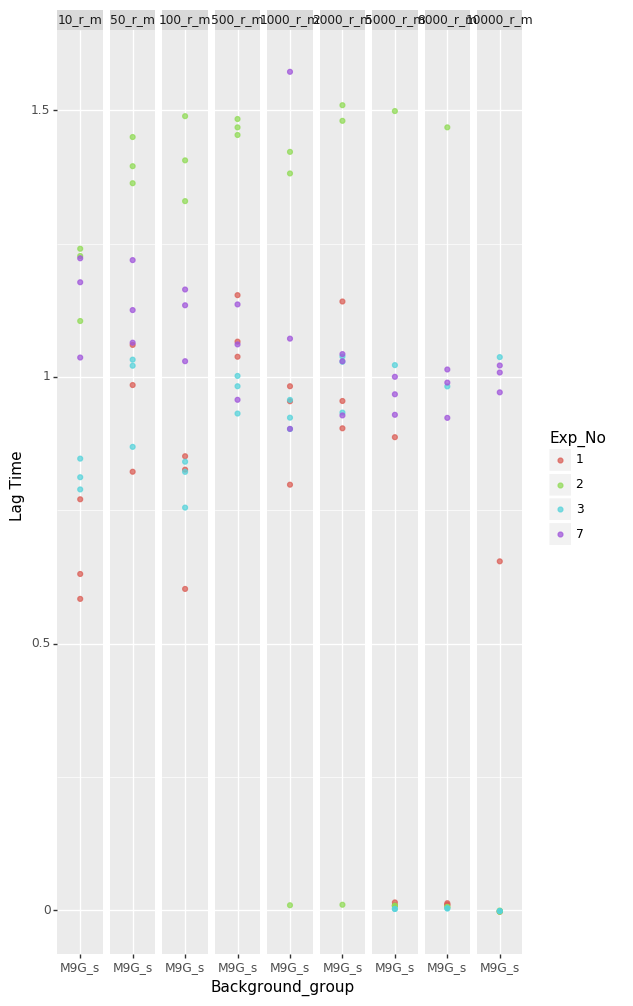

<ggplot: (-9223371959139215920)>


In [13]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm"
condition_subset = ["10_r_m", "50_r_m", "100_r_m",
                      "500_r_m", "1000_r_m", "2000_r_m",
                      "5000_r_m", "8000_r_m", "10000_r_m"
                     ]
condition_type = "magnesium_normalized"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

norm_list = []
data_to_plot_sub = data_to_plot_sub.drop_duplicates(["Well", "Exp_No"])

for exp_no in data_to_plot_sub["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "2000_r_m"]["lagC_adj"].tolist()[0]
    pilot["lagC_adj_norm"] = pilot["lagC_adj"] / norm_value
    norm_list.append(pilot)


template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

In [14]:
normalized_lagC[normalized_lagC["Condition"] == "2000_r_m"][["Condition", "lagC_adj", "lagC_adj_norm", "Exp_No"]].groupby("Exp_No").mean().reset_index()

,Exp_No,lagC_adj,lagC_adj_norm
0,1,105.8450,1.0000
1,2,197.4661,1.0000
2,3,444.4326,1.0000
3,7,334.7612,1.0000


The 2000_r_m points are not exactly one because I am normalizing to the mean of three observations.

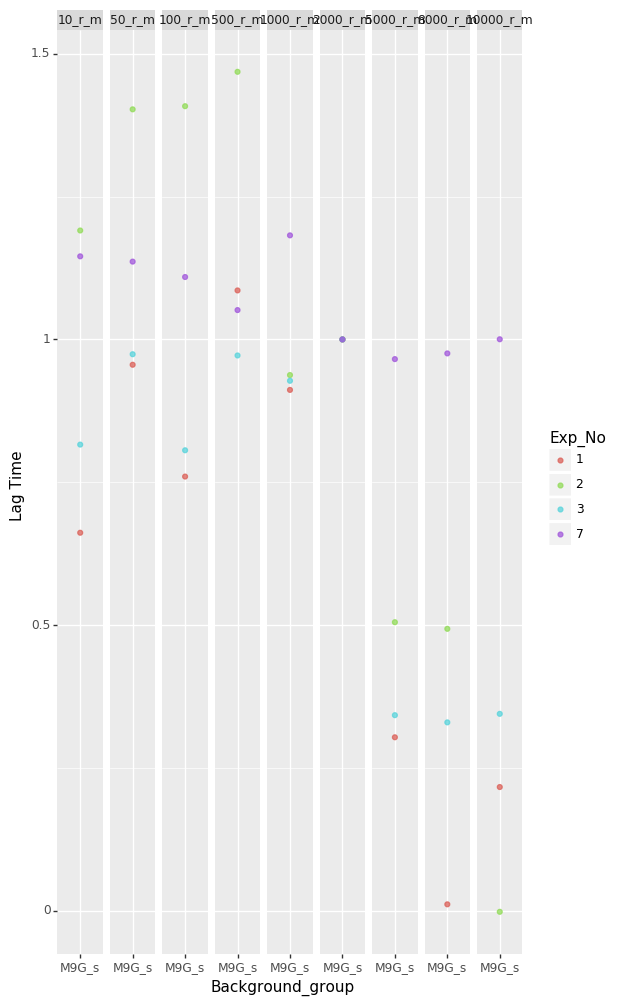

<ggplot: (-9223371959024242640)>


In [15]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm_mean"
condition_subset = ["10_r_m", "50_r_m", "100_r_m",
                      "500_r_m", "1000_r_m", "2000_r_m",
                      "5000_r_m", "8000_r_m", "10000_r_m"
                     ]
condition_type = "magnesium_normalized_mean"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

data_to_plot_sub_g = data_to_plot_sub.groupby(["Exp_No", "Condition"])
data_to_plot_sub_g = data_to_plot_sub_g[['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
data_to_plot_sub_g = data_to_plot_sub_g.mean().reset_index()

norm_list = []

for exp_no in data_to_plot_sub_g["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "2000_r_m"]["lagC_adj"].tolist()[0]
    pilot_g["lagC_adj_norm_mean"] = pilot_g["lagC_adj"] / norm_value
    pilot_g = pd.DataFrame(pilot_g)
    pilot_g["Exp_No"] = exp_no
    pilot_g["Background_group"] = pilot["Background_group"].tolist()[0]
    norm_list.append(pilot_g)

template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

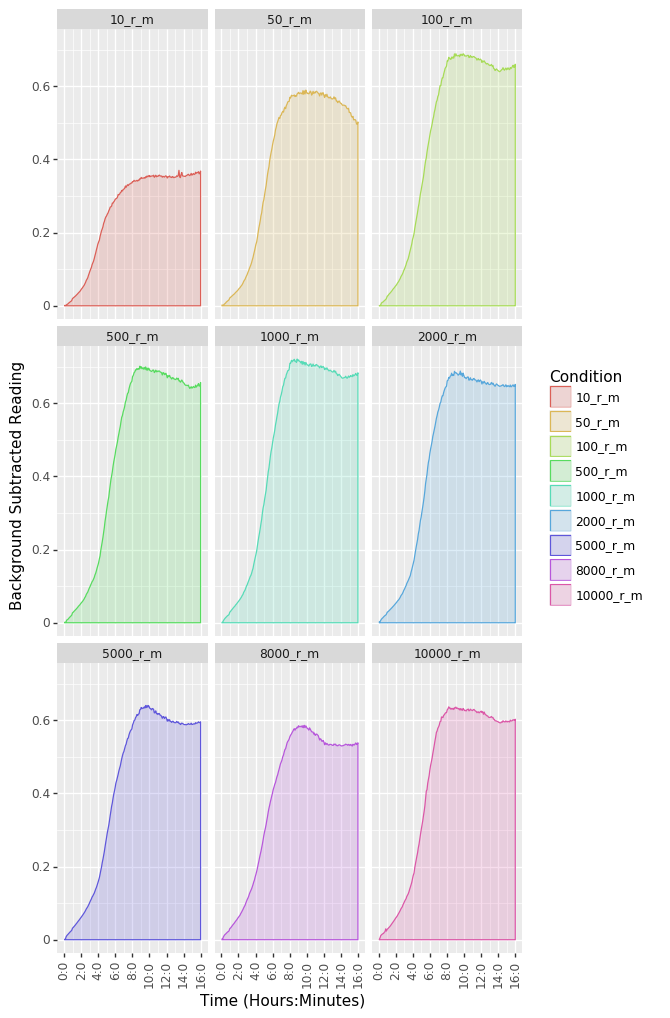

<ggplot: (-9223371959024072996)>


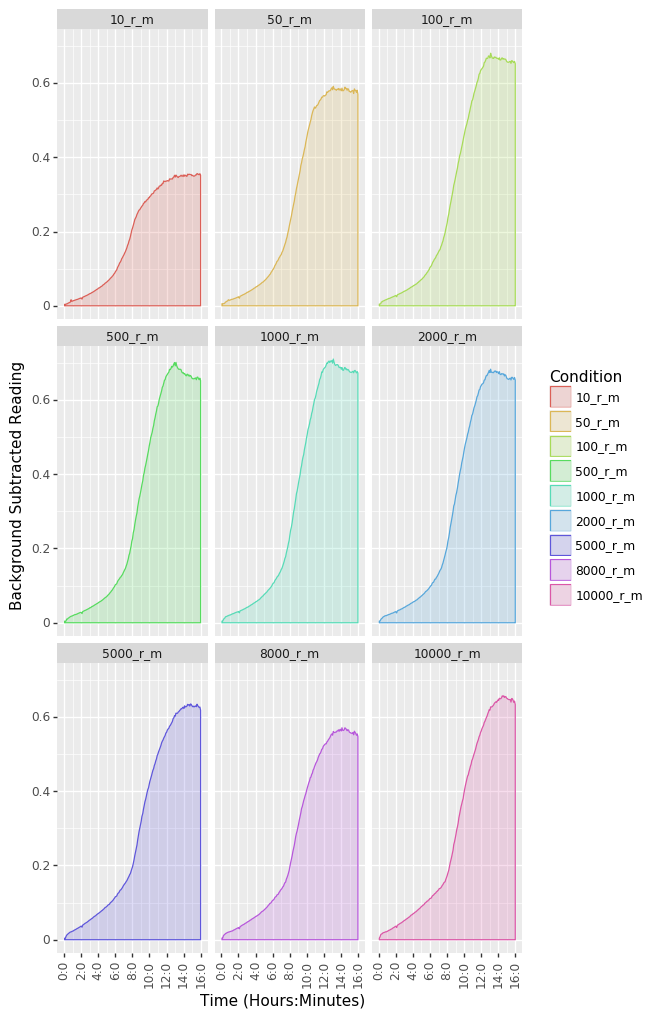

<ggplot: (-9223371959138761108)>


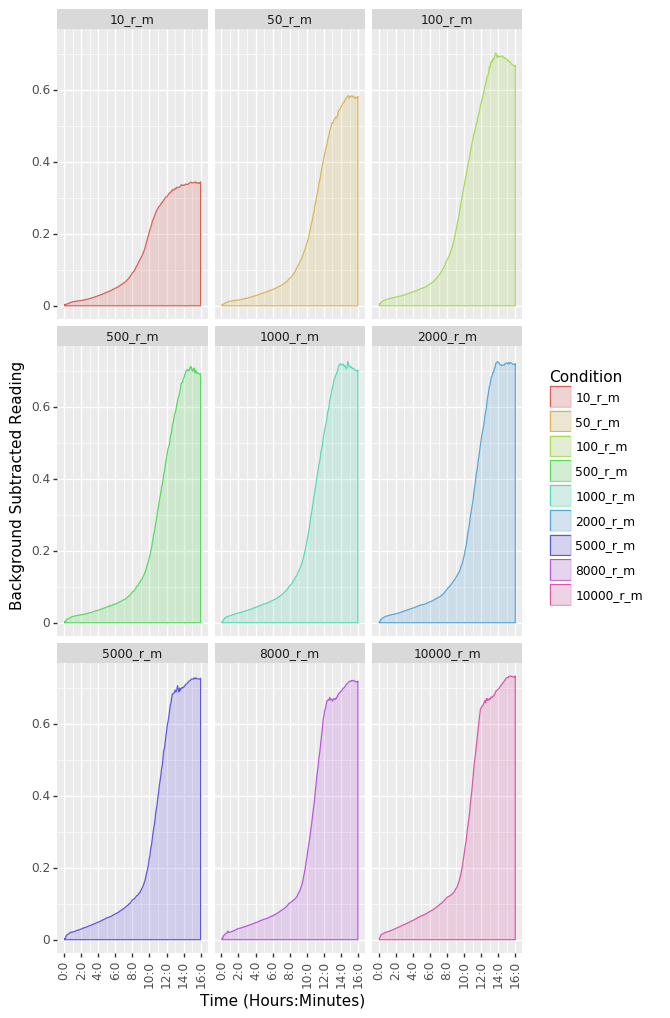

<ggplot: (-9223371959138782580)>


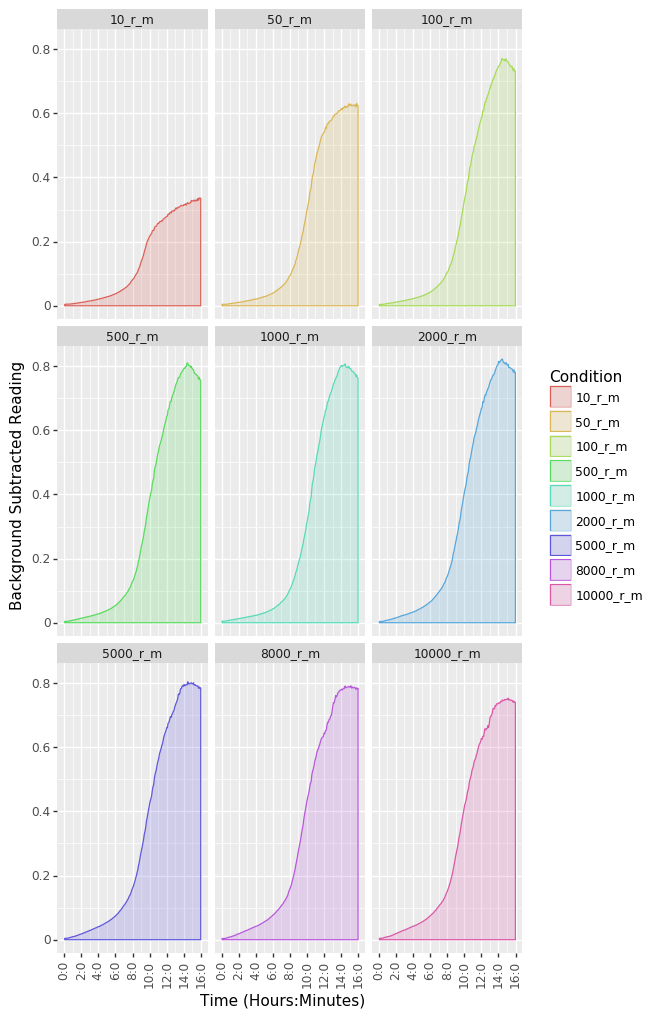

<ggplot: (-9223371959137697316)>


In [16]:
#### User Input
endpt = endpt_list[0]
user_params = utilities.scaling_params(endpt)
# Choose if the background is subtracted from the readings
plot_background_subtracted = True
condition_subset = ["10_r_m", "50_r_m", "100_r_m",
                      "500_r_m", "1000_r_m", "2000_r_m",
                      "5000_r_m", "8000_r_m", "10000_r_m"
                     ]
channel_to_plot = 'OD600'
condition_type = "magnesium"
file_type = ".jpg"
#### 

data_to_use = combined_new


xvar = "Time"
if plot_background_subtracted:
    yvar= 'Bgd_subtracted_reading'
    bs = ""
    y_axis_name = "Background Subtracted Reading"
else:
    yvar= 'Reading'
    bs = "no_bs_"
    y_axis_name = "Reading"

data_to_plot = data_to_use[(data_to_use.Channel==channel_to_plot) & (data_to_use.Condition.isin(condition_subset))] 

for exp_no in data_to_plot["Exp_No"].unique():
    data_to_plot_i = data_to_plot[data_to_plot["Exp_No"] == exp_no]
    data_to_plot_i["Condition"] = data_to_plot_i["Condition"].astype("category")
    data_to_plot_i["Condition"] = data_to_plot_i["Condition"].cat.reorder_categories(condition_subset)
    group_mean = data_to_plot_i.groupby(["Time", "Condition"]).mean().reset_index()

    plotnine.options.figure_size=(figure_width,figure_height)

    auc_hours = ggplot(group_mean, aes(x=xvar, y=yvar, color='Condition',group='Condition'))+\
        geom_area(aes(fill = "Condition", group = "Condition"), alpha = 0.2, position = "identity") +\
        xlab("Time (Hours:Minutes)") +\
        ylab(y_axis_name) +\
        scale_x_continuous(breaks = user_params[0], labels = user_params[4], limits = user_params[5]) +\
        theme(axis_text_x = element_text(rotation = 90)) +\
        facet_wrap("~Condition")
    print(auc_hours)

#     auc_hours.save(os.path.join(plot_path+"auc_hours_")+bs+channel_to_plot+'_'+condition_type+"_"+str(exp_no)+file_type, height=figure_width, width=figure_height)

## Calcium

In [17]:
data_to_use["Condition"].unique()

array(['Blank', '10_r_m', '50_r_m', '100_r_m', '500_r_m', '1000_r_m',
       '2000_r_m', '5000_r_m', '8000_r_m', '10000_r_m', '100_r_cc',
       '250_r_cc', '500_r_cc', '1000_r_cc', '5000_r_cc', '10000_r_cc',
       '100000_r_cc', '500000_r_cc', '1000000_r_cc', '100000_r_cc_3',
       '500000_r_cc_3', '1000000_r_cc_3', '100000_r_cc_2',
       '500000_r_cc_2', '1000000_r_cc_2', '5_r_ph', '5_5_r_ph', '6_r_ph',
       '7_1_r_ph', '10_r_p', '25_r_p', '50_r_p', '75_r_p', '100_r_p',
       '24_r_r', '72_r_r', '24_c_r', '72_c_r', '24_r_c', '72_r_c',
       '24_c_c', '72_c_c'], dtype=object)

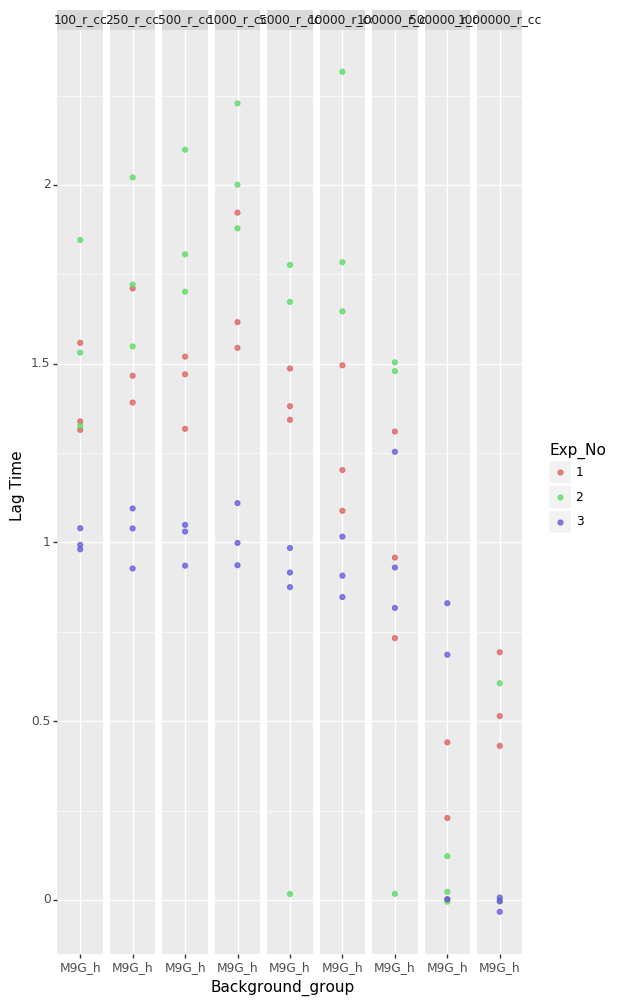

<ggplot: (-9223371959024172600)>


In [18]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm"
condition_subset = ["100_r_cc", "250_r_cc", '500_r_cc',
                    '1000_r_cc', '5000_r_cc', '10000_r_cc',
                    '100000_r_cc', '500000_r_cc', '1000000_r_cc'
                     ]
condition_type = "calcium_normalized"
file_type = ".jpg"
####

data_to_plot = combined_new

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

norm_list = []
data_to_plot_sub = data_to_plot_sub.drop_duplicates(["Well", "Exp_No"])

for exp_no in data_to_plot_sub["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "100000_r_cc"]["lagC_adj"].tolist()[0]
    pilot["lagC_adj_norm"] = pilot["lagC_adj"] / norm_value
    norm_list.append(pilot)


template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC.head(27)
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

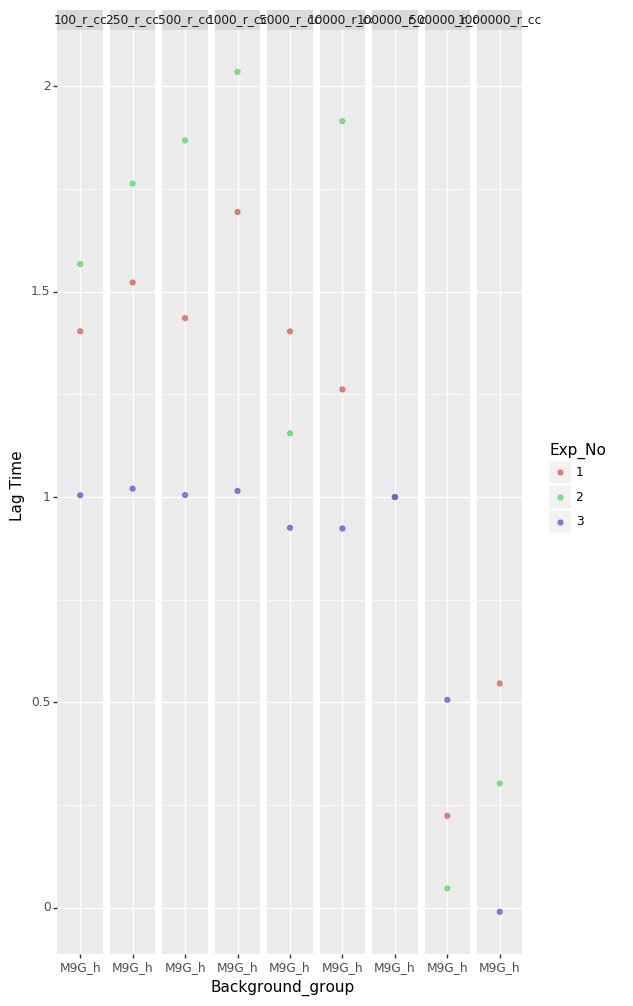

<ggplot: (-9223371959142615476)>


In [19]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm_mean"
condition_subset = ["100_r_cc", "250_r_cc", '500_r_cc',
                    '1000_r_cc', '5000_r_cc', '10000_r_cc',
                    '100000_r_cc', '500000_r_cc', '1000000_r_cc'
                     ]
condition_type = "calcium_normalized_mean"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

data_to_plot_sub_g = data_to_plot_sub.groupby(["Exp_No", "Condition"])
data_to_plot_sub_g = data_to_plot_sub_g[['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
data_to_plot_sub_g = data_to_plot_sub_g.mean().reset_index()

norm_list = []

for exp_no in data_to_plot_sub_g["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "100000_r_cc"]["lagC_adj"].tolist()[0]
    pilot_g["lagC_adj_norm_mean"] = pilot_g["lagC_adj"] / norm_value
    pilot_g = pd.DataFrame(pilot_g)
    pilot_g["Exp_No"] = exp_no
    pilot_g["Background_group"] = pilot["Background_group"].tolist()[0]
    norm_list.append(pilot_g)

template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

## pH

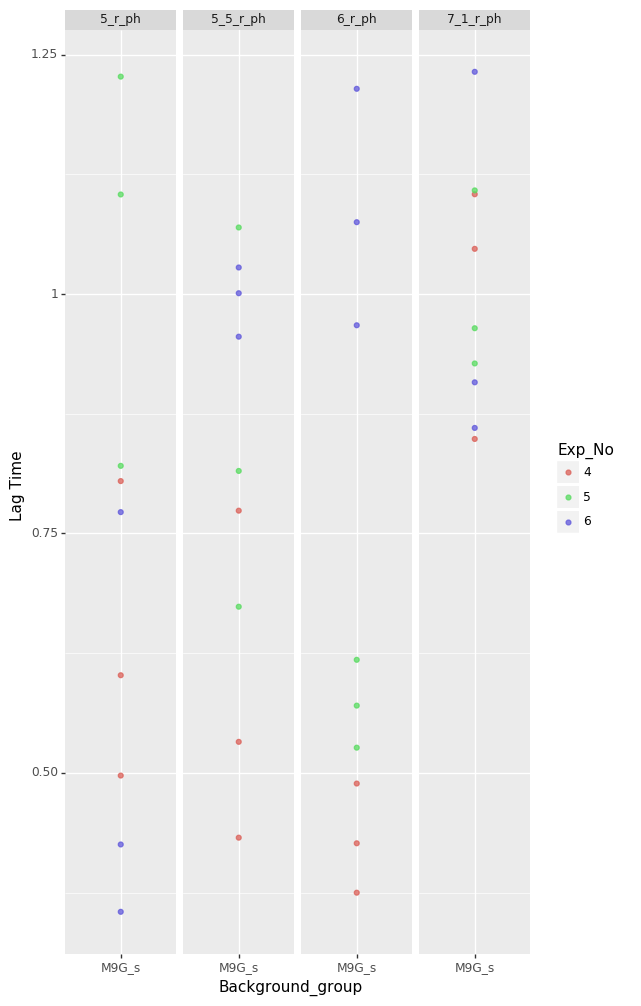

<ggplot: (-9223371959137697932)>


In [20]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm"
condition_subset = ["5_r_ph", "5_5_r_ph",
                    "6_r_ph", "7_1_r_ph"
                     ]
condition_type = "ph_normalized"
file_type = ".jpg"
####

data_to_plot = combined_new

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

norm_list = []
data_to_plot_sub = data_to_plot_sub.drop_duplicates(["Well", "Exp_No"])

for exp_no in data_to_plot_sub["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "7_1_r_ph"]["lagC_adj"].tolist()[0]
    pilot["lagC_adj_norm"] = pilot["lagC_adj"] / norm_value
    norm_list.append(pilot)


template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC.head(27)
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

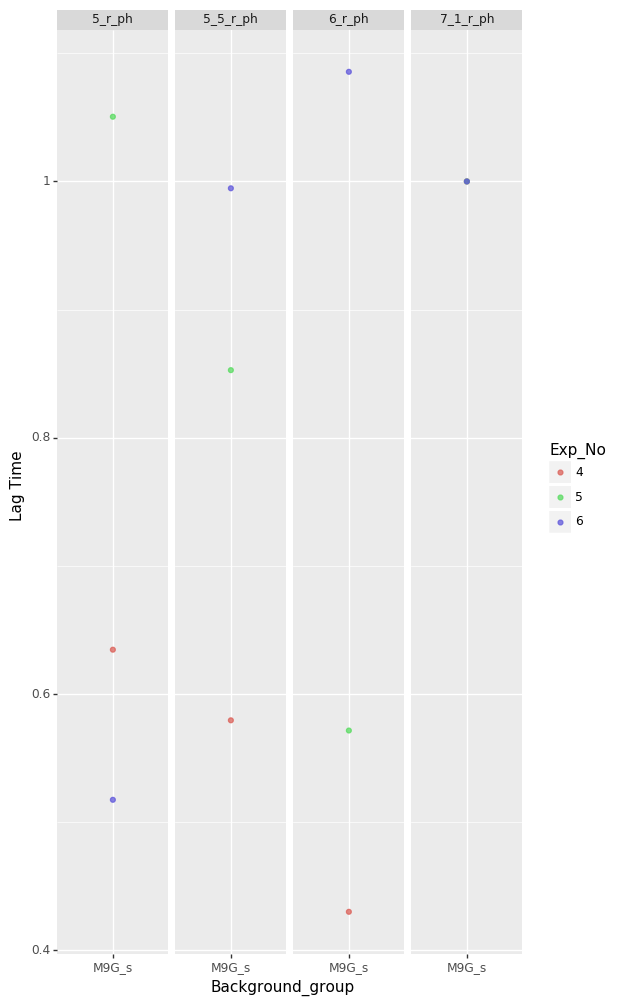

<ggplot: (-9223371959137697828)>


In [21]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm_mean"
condition_subset = ["5_r_ph", "5_5_r_ph",
                    "6_r_ph", "7_1_r_ph"
                     ]
condition_type = "ph_normalized_mean"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

data_to_plot_sub_g = data_to_plot_sub.groupby(["Exp_No", "Condition"])
data_to_plot_sub_g = data_to_plot_sub_g[['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
data_to_plot_sub_g = data_to_plot_sub_g.mean().reset_index()

norm_list = []

for exp_no in data_to_plot_sub_g["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "7_1_r_ph"]["lagC_adj"].tolist()[0]
    pilot_g["lagC_adj_norm_mean"] = pilot_g["lagC_adj"] / norm_value
    pilot_g = pd.DataFrame(pilot_g)
    pilot_g["Exp_No"] = exp_no
    pilot_g["Background_group"] = pilot["Background_group"].tolist()[0]
    norm_list.append(pilot_g)

template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

## Pi

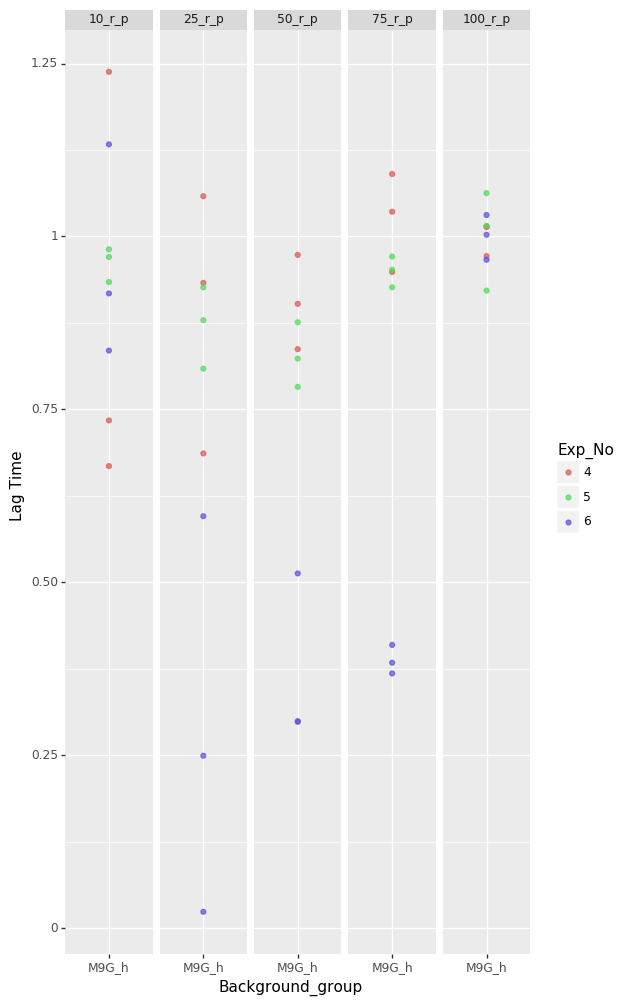

<ggplot: (-9223371959139292876)>


In [22]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm"
condition_subset = ["10_r_p", "25_r_p",
                    "50_r_p", "75_r_p",
                    "100_r_p"
                     ]
condition_type = "pi_normalized"
file_type = ".jpg"
####

data_to_plot = combined_new

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

norm_list = []
data_to_plot_sub = data_to_plot_sub.drop_duplicates(["Well", "Exp_No"])

for exp_no in data_to_plot_sub["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "100_r_p"]["lagC_adj"].tolist()[0]
    pilot["lagC_adj_norm"] = pilot["lagC_adj"] / norm_value
    norm_list.append(pilot)


template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC.head(27)
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

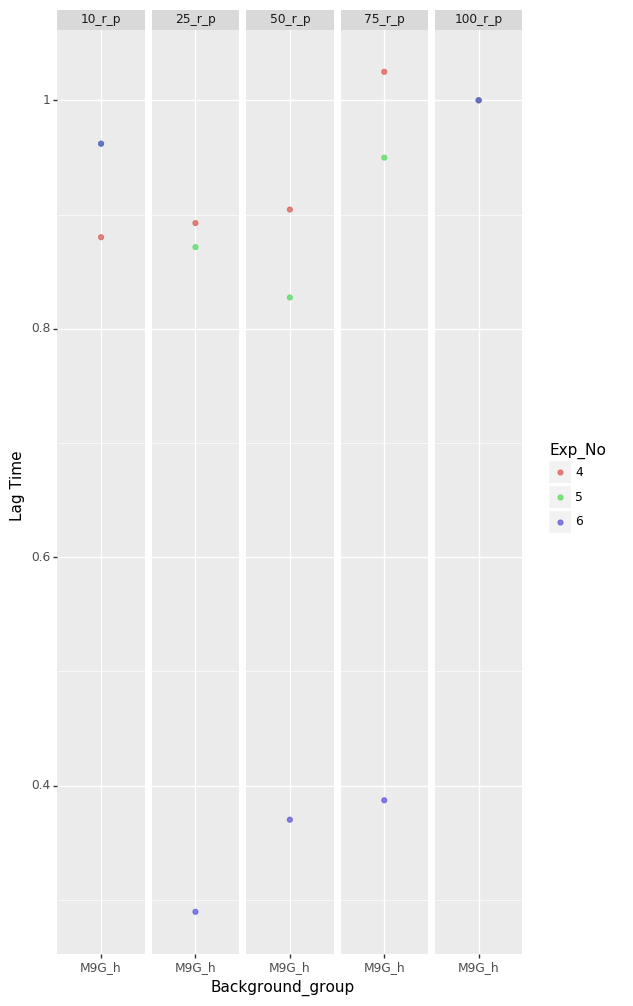

<ggplot: (-9223371959139279508)>


In [23]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj_norm_mean"
condition_subset = ["10_r_p", "25_r_p",
                    "50_r_p", "75_r_p",
                    "100_r_p"
                     ]
condition_type = "pi_normalized_mean"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

data_to_plot_sub_g = data_to_plot_sub.groupby(["Exp_No", "Condition"])
data_to_plot_sub_g = data_to_plot_sub_g[['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
data_to_plot_sub_g = data_to_plot_sub_g.mean().reset_index()

norm_list = []

for exp_no in data_to_plot_sub_g["Exp_No"].unique():
    pilot = data_to_plot_sub[data_to_plot_sub["Exp_No"] == exp_no][['Channel', 'Cycle Nr.', 'Time', 'Well', 'Reading', 'Condition', 'lagC_adj', "Exp_No", "Background_group"]]
    pilot_g = pilot.groupby(["Condition"]).mean().reset_index()
    norm_value = pilot_g[pilot_g["Condition"] == "100_r_p"]["lagC_adj"].tolist()[0]
    pilot_g["lagC_adj_norm_mean"] = pilot_g["lagC_adj"] / norm_value
    pilot_g = pd.DataFrame(pilot_g)
    pilot_g["Exp_No"] = exp_no
    pilot_g["Background_group"] = pilot["Background_group"].tolist()[0]
    norm_list.append(pilot_g)

template = pd.DataFrame(norm_list[0])
df = template
for df_to_concat in norm_list[1:]:
    df = pd.concat([df, df_to_concat])

normalized_lagC = df
normalized_lagC["Exp_No"] = normalized_lagC["Exp_No"].astype("category")


plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(normalized_lagC, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point(alpha = 0.75) +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)

## Timepoints

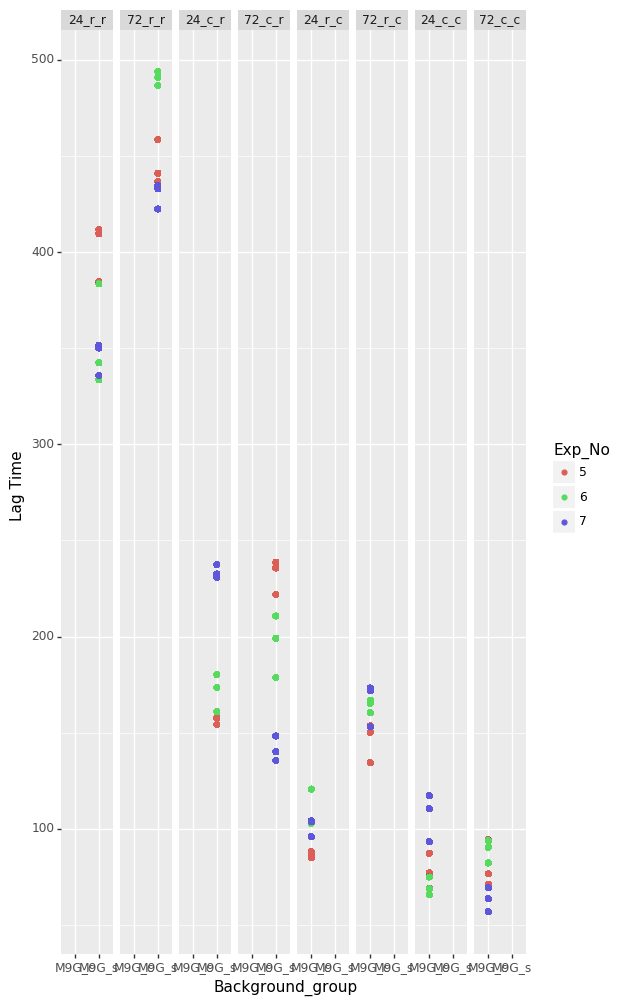

<ggplot: (-9223371959139293588)>


In [24]:
#### User Params
channel_to_plot = 'OD600'
xvar = "Background_group"
yvar = "lagC_adj"
condition_subset = [ '24_r_r', '72_r_r', 
                      '24_c_r', '72_c_r', 
                      '24_r_c', '72_r_c',
                      '24_c_c', '72_c_c'
                     ]
condition_type = "timepoints"
file_type = ".jpg"
####

data_to_plot_sub = data_to_plot[data_to_plot.Channel == channel_to_plot]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub["Condition"] != "Blank"]
data_to_plot_sub = data_to_plot_sub[data_to_plot_sub.Condition.isin(condition_subset)]
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].astype("category")
data_to_plot_sub["Condition"] = data_to_plot_sub["Condition"].cat.reorder_categories(condition_subset)

plotnine.options.figure_size=(figure_width, figure_height)

lagtime_by_condition = ggplot(data_to_plot_sub, aes(x = xvar, y = yvar, color = 'Exp_No', group = 'Condition'))+\
    geom_point() +\
    facet_wrap("~Condition", nrow = 1)+\
    ylab("Lag Time")
print(lagtime_by_condition)

# lagtime_by_condition.save(plot_path+"lagtime_by_condition_"+channel_to_plot+'_'+condition_type+file_type, height=figure_width, width=figure_height)